In [1]:
# core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import random

# images
from PIL import Image
from IPython.display import display

# file download
from zipfile import ZipFile
from kaggle.api.kaggle_api_extended import KaggleApi

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# logging and performance
from time import time
from sklearn.metrics import classification_report

# styles
plt.style.use('dark_background')

# authentication
api = KaggleApi()
api.authenticate()

# gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\Keith\miniconda3\envs\cuny\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hyperparameters
NUM_EPOCHS = 100
BATCH_SIZE = 32
OPTIMIZER = optim.Adam
LEARNING_RATE = 0.001
DROPOUT = 0.3

# Load Data

In [3]:
# clear out data directory
for folder in os.listdir('data'):
    shutil.rmtree(f'data/{folder}')

# download dataset with Kaggle API
api.dataset_download_files('puneet6060/intel-image-classification')

# designate downloaded file as zip, and unzip
zf = ZipFile('intel-image-classification.zip')
zf.extractall('data')
zf.close()

# delete downloaded zip and extracted csv - keep your directory clean!
os.remove('intel-image-classification.zip')

# clean up folder structure
for subset in ['train', 'test']:

    if not os.path.exists(f'data/{subset}'):
        os.makedirs(f'data/{subset}')

    base_path = f'data/seg_{subset}'
    source_path = f'data/seg_{subset}/seg_{subset}'
    target_path = f'data/{subset}'

    num_files = 0
    for folder in os.listdir(source_path):
        shutil.move(os.path.join(source_path, folder), os.path.join(target_path, folder))
        num_files += len(os.listdir(os.path.join(target_path, folder)))
    print(f'Number of {subset} files: {num_files}')

    os.rmdir(source_path)
    os.rmdir(base_path)

num_pred_files = len(os.listdir('data/seg_pred/seg_pred'))
print(f'Number of pred files: {num_pred_files}')
for img in os.listdir('data/seg_pred/seg_pred'):
    os.remove(f'data/seg_pred/seg_pred/{img}')
os.rmdir('data/seg_pred/seg_pred')
os.rmdir('data/seg_pred')

Number of train files: 14034
Number of test files: 3000
Number of pred files: 7301


# EDA

#### View Images

'Image Class: buildings'

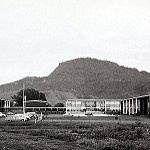

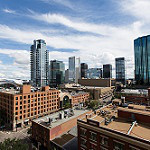

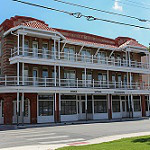

'Image Class: forest'

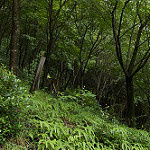

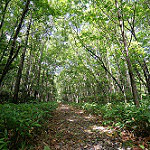

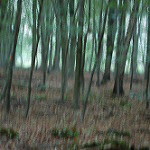

'Image Class: glacier'

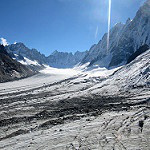

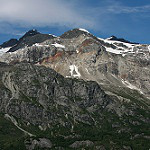

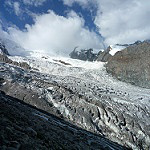

'Image Class: mountain'

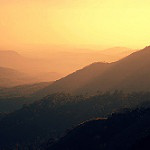

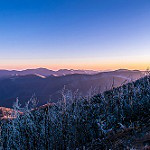

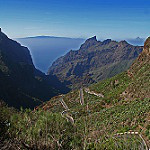

'Image Class: sea'

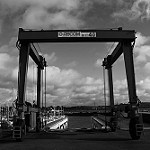

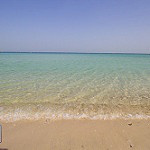

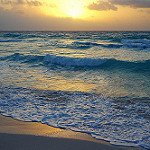

'Image Class: street'

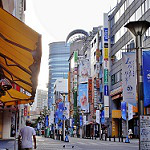

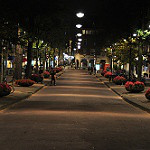

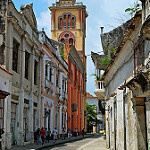

In [4]:
for label in os.listdir('data/train'):
    display(f'Image Class: {label}')
    for idx in range(3):
        img_filename = os.listdir(f'data/train/{label}')[idx]
        img = Image.open(f'data/train/{label}/{img_filename}')
        display(img)

#### Distribution Across Classes

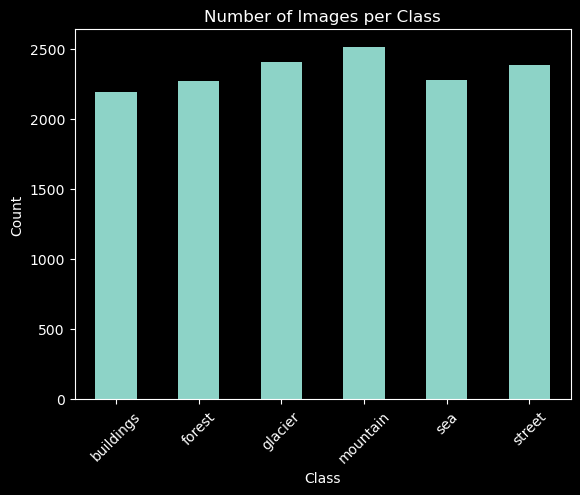

In [5]:
class_counts = {}
for folder in os.listdir('data/train'):
    class_path = f'data/train/{folder}'
    if os.path.isdir(class_path):
        class_counts[folder] = len(os.listdir(class_path))

pd.DataFrame(class_counts, index=['count']).transpose().plot(kind='bar')
plt.title('Number of Images per Class')
plt.ylabel('Count')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.legend().remove()
plt.show()

#### Distribution of Image Size and Quality

In [6]:
sizes = []
for folder in os.listdir('data/train'):
    class_path = f'data/train/{folder}'
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        with Image.open(image_path) as img:
            sizes.append(img.size)

sizes = np.array(sizes)
width_vals, width_cts = np.unique(sizes[:, 0], return_counts=True)
height_vals, height_cts = np.unique(sizes[:, 1], return_counts=True)

print(
    f'Widths: {width_vals}'
    f'\nCounts: {width_cts}'
    f'\n\nHeights: {height_vals}' 
    f'\nCounts: {height_cts}'
)

Widths: [150]
Counts: [14034]

Heights: [ 76  81  97 100 102 103 105 108 110 111 113 115 119 120 123 124 131 133
 134 135 136 140 141 142 143 144 145 146 147 149 150]
Counts: [    1     1     1     1     1     1     1     2     1     3     7     1
     1     1     2     1     1     1     2     3     2     1     1     2
     2     2     1     2     1     1 13986]


#### Pixel Intensity Distribution

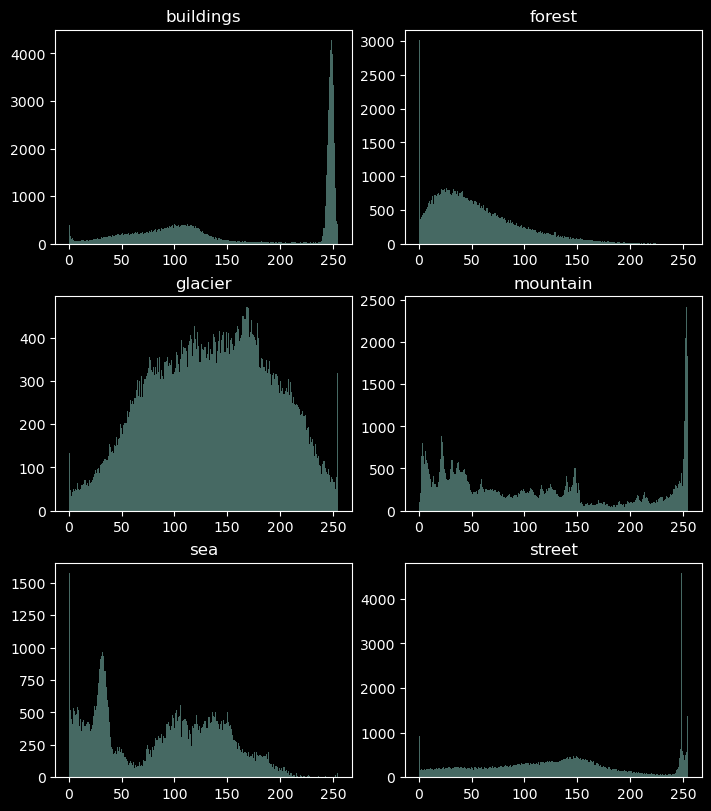

In [7]:
# For a single, random image in each class
fig, axes = plt.subplots(3, 2, figsize=(7,8), layout='constrained')
for folder, ax in zip(os.listdir('data/train'), axes.ravel()):
    class_path = f'data/train/{folder}'
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        with Image.open(image_path) as img:
            img_array = np.array(img)
            ax.hist(img_array.ravel(), bins=256, alpha=0.5, label=f'{folder} (sample)')
            break
    ax.set_title(folder)

plt.show()

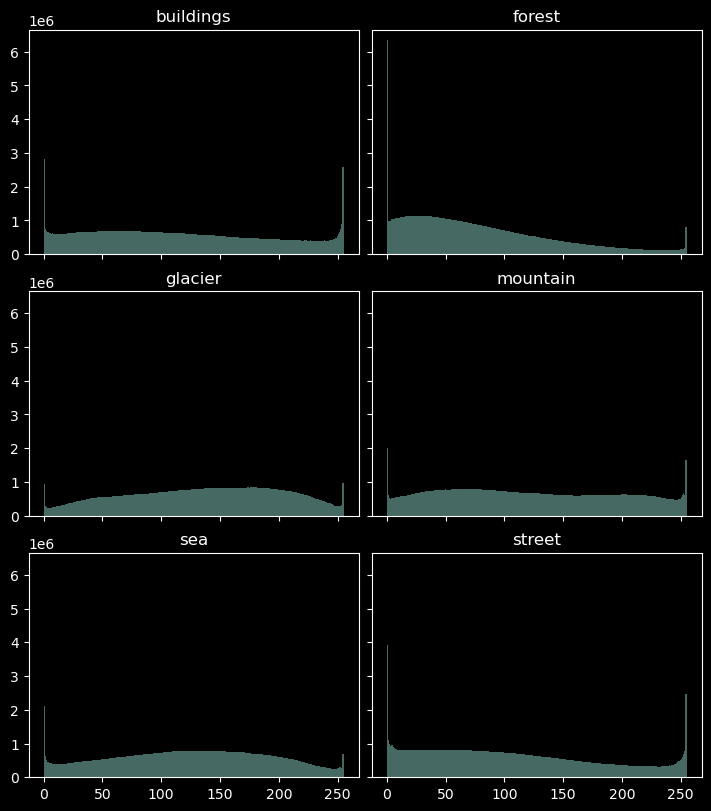

In [8]:
# Aggregated across all images
fig, axes = plt.subplots(3, 2, figsize=(7, 8), layout='constrained', sharex=True, sharey=True)

# Iterate over each class folder
for folder, ax in zip(os.listdir('data/train'), axes.ravel()):
    class_path = f'data/train/{folder}'
    total_hist = np.zeros(256)  # Initialize a histogram to accumulate pixel values

    # Accumulate histogram data from all images in the class folder
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        with Image.open(image_path) as img:
            img_array = np.array(img)
            hist, _ = np.histogram(img_array.ravel(), bins=256, range=[0, 256])
            total_hist += hist  # Accumulate the histograms

    # Plot the accumulated histogram
    ax.hist(np.arange(256), weights=total_hist, bins=256, alpha=0.5, label=f'{folder} (aggregate)')
    ax.set_title(folder)
    ax.legend().remove()

plt.show()

#### Distribution Across RGB Color Channels

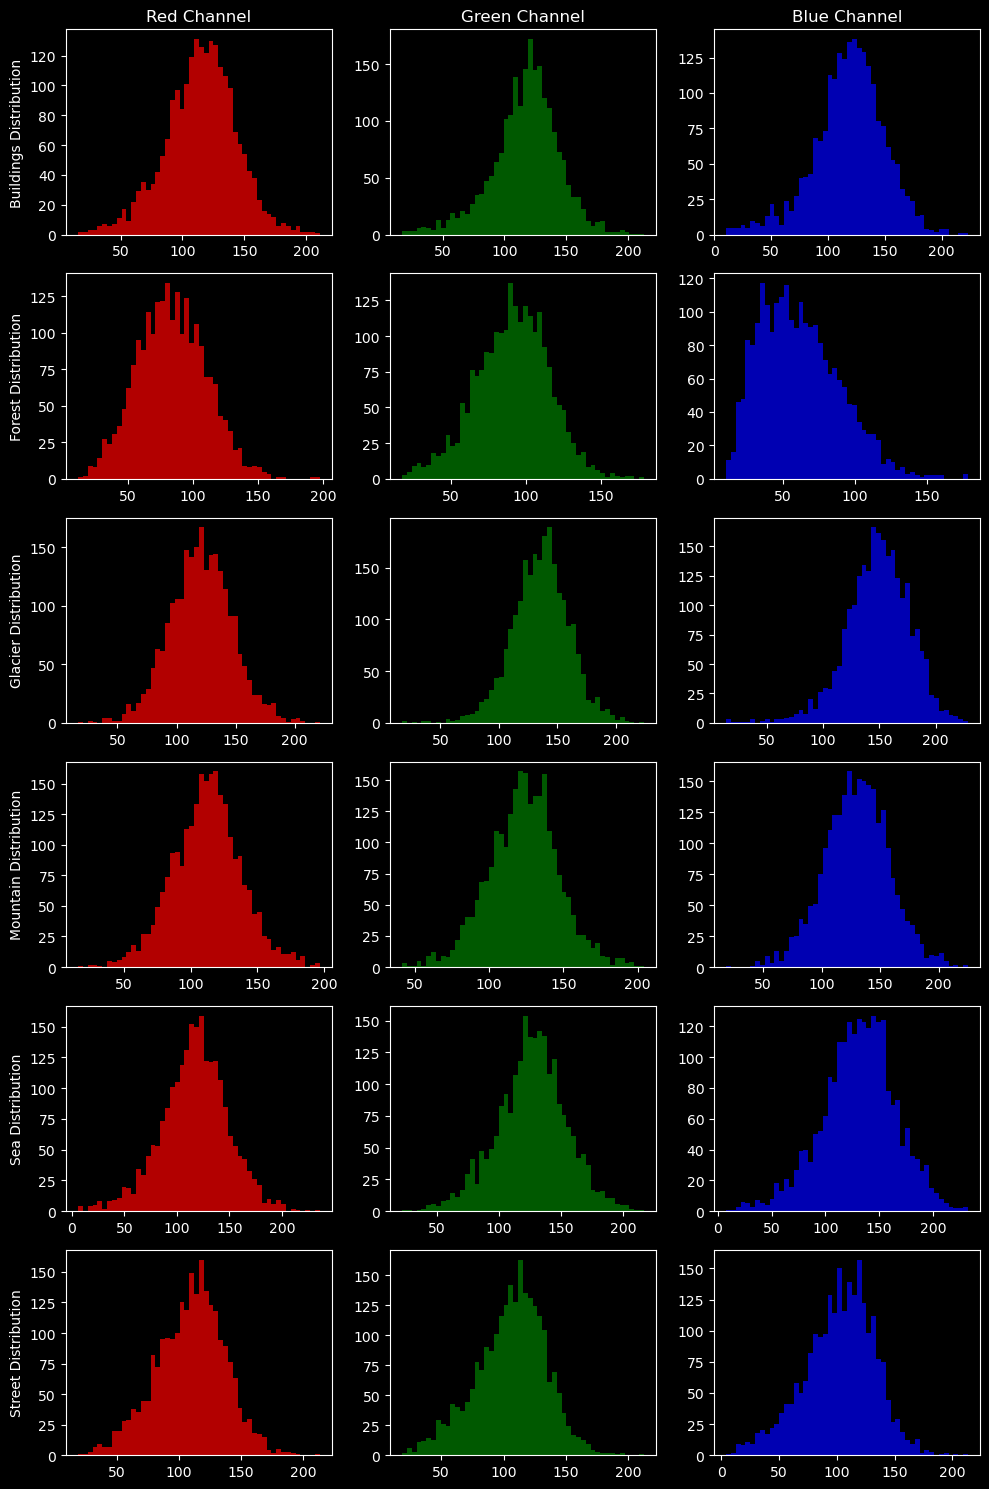

In [9]:
# Set up the plot
fig, axes = plt.subplots(6, 3, figsize=(10, 15), layout='tight')

# Set titles for columns
axes[0, 0].set_title('Red Channel')
axes[0, 1].set_title('Green Channel')
axes[0, 2].set_title('Blue Channel')

# Iterate over each class directory
for folder, ax_row in zip(os.listdir('data/train'), axes):
    class_path = f'data/train/{folder}'
    colors = []

    # Collect all colors in this class
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        with Image.open(image_path) as img:
            colors.append(np.mean(np.array(img), axis=(0, 1)))
    colors = np.array(colors)

    # Plot histograms for each color channel
    ax_row[0].hist(colors[:, 0], bins=50, color='red', alpha=0.7)
    ax_row[1].hist(colors[:, 1], bins=50, color='green', alpha=0.7)
    ax_row[2].hist(colors[:, 2], bins=50, color='blue', alpha=0.7)

    # Set class label as the row title
    ax_row[0].set_ylabel(f'{folder.title()} Distribution')

plt.tight_layout()
plt.show()


#### Check for Corrupt Images

In [10]:
bad_files = []
for folder in os.listdir('data/train'):
    class_path = f'data/train/{folder}'
    for i, image_name in enumerate(os.listdir(class_path)):
        try:
            image_path = os.path.join(class_path, image_name)
            with Image.open(image_path) as img:
                img.verify()
        except (IOError, SyntaxError) as e:
            print('Bad file:', image_name)
            bad_files.append(f'{folder}/{image_name}')

print(f'Number of bad files: {len(bad_files)}')

Number of bad files: 0


# Preprocessing

In [11]:
# set up vars
train_dir = 'data/train'
val_dir = 'data/val'
num_val_samples = 3000
num_val_samples_per_class = num_val_samples // len(os.listdir(train_dir))

# create validation folder
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

for label in os.listdir(train_dir):
    new_label_dir = os.path.join(val_dir, label)
    if not os.path.exists(new_label_dir):
        os.makedirs(new_label_dir)

print(f'Folders in {val_dir}:', os.listdir(val_dir))

# move random train images to validation
for label in os.listdir(train_dir):
    train_label_dir = os.path.join(train_dir, label)
    val_label_dir = os.path.join(val_dir, label)

    imgs = os.listdir(train_label_dir)
    random.shuffle(imgs)

    for img in imgs[:num_val_samples_per_class]:
        source_path = os.path.join(train_label_dir, img)
        target_path = os.path.join(val_label_dir, img)
        shutil.move(source_path, target_path)

for subset in ['train', 'val', 'test']:
    num_files = 0
    for folder in os.listdir(f'data/{subset}'):
        num_files += len(os.listdir(f'data/{subset}/{folder}'))
    print(f'Number of {subset} files: {num_files}')

Folders in data/val: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number of train files: 11034
Number of val files: 3000
Number of test files: 3000


In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(os.path.join('data', x), data_transforms[x])
    for x in ['train', 'val', 'test']
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
    for x in ['train', 'val', 'test']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

print(
    f'Class names: {class_names}'
    f'\nDataset sizes: {dataset_sizes}'
)

Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Dataset sizes: {'train': 11034, 'val': 3000, 'test': 3000}


# Model Setup and Baseline Training

In [13]:
model = models.resnet50(weights='IMAGENET1K_V1')
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
# Freeze all the parameters in the network
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer with a new one with 6 output classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)

model.fc

Linear(in_features=2048, out_features=6, bias=True)

In [15]:
# Transfer the model to GPU if available
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = OPTIMIZER(model.fc.parameters(), lr=LEARNING_RATE)

# Set up variables
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
start = time()

# Train model
for epoch in range(NUM_EPOCHS):

    if epoch % (NUM_EPOCHS // 10) == 0 or epoch == NUM_EPOCHS - 1:
        print(f'\nEpoch {epoch + 1}/{NUM_EPOCHS} - Time Elapsed: {(time() - start) / 60:.2f} minutes\n----------')

    # Repeat for training and validation
    for phase in ['train', 'val']:
        # Set model to training mode or evaluation mode
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)

        if epoch % (NUM_EPOCHS // 10) == 0 or epoch == NUM_EPOCHS - 1:
            print(f'{phase.title()} Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}')

torch.save(model, 'models/baseline_model.pt')


Epoch 1/100 - Time Elapsed: 0.00 minutes
----------
Train Loss: 0.5581 - Accuracy: 0.7974
Val Loss: 0.3013 - Accuracy: 0.8840

Epoch 11/100 - Time Elapsed: 4.57 minutes
----------
Train Loss: 0.3819 - Accuracy: 0.8596
Val Loss: 0.2531 - Accuracy: 0.9050

Epoch 21/100 - Time Elapsed: 9.16 minutes
----------
Train Loss: 0.3760 - Accuracy: 0.8599
Val Loss: 0.2349 - Accuracy: 0.9167

Epoch 31/100 - Time Elapsed: 13.69 minutes
----------
Train Loss: 0.3626 - Accuracy: 0.8690
Val Loss: 0.2442 - Accuracy: 0.9180

Epoch 41/100 - Time Elapsed: 18.19 minutes
----------
Train Loss: 0.3542 - Accuracy: 0.8689
Val Loss: 0.2372 - Accuracy: 0.9123

Epoch 51/100 - Time Elapsed: 22.71 minutes
----------
Train Loss: 0.3400 - Accuracy: 0.8734
Val Loss: 0.3291 - Accuracy: 0.8887

Epoch 61/100 - Time Elapsed: 27.21 minutes
----------
Train Loss: 0.3350 - Accuracy: 0.8765
Val Loss: 0.2361 - Accuracy: 0.9153

Epoch 71/100 - Time Elapsed: 31.73 minutes
----------
Train Loss: 0.3287 - Accuracy: 0.8775
Val Loss

#### View Loss Over Epochs

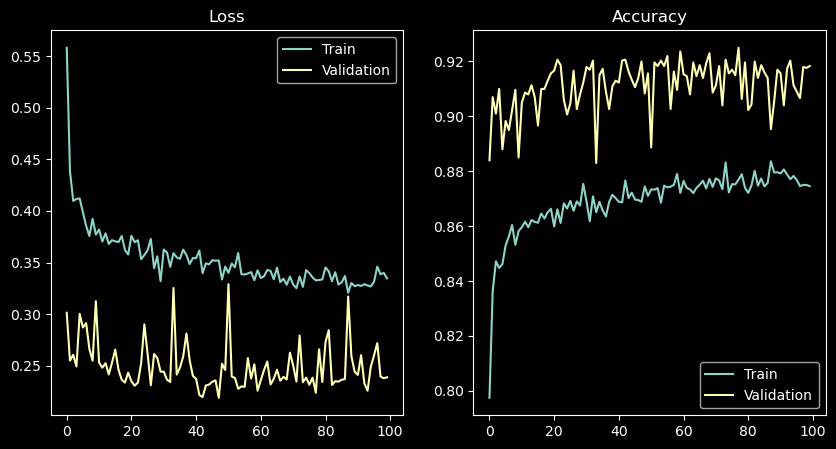

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(train_losses, label='Train')
axes[0].plot(val_losses, label='Validation')
axes[0].set_title('Loss')
axes[0].legend()

axes[1].plot([x.detach().cpu().numpy() for x in train_accuracies], label='Train')
axes[1].plot([x.detach().cpu().numpy() for x in val_accuracies], label='Validation')
axes[1].set_title('Accuracy')
axes[1].legend()

plt.show()

# Error Analysis

#### Classification Report - Training Data

In [17]:
# Set up variables
true_labels = []
pred_labels = []

# Loop through validation set
for inputs, labels in dataloaders['train']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Generate predictions
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Convert to numpy arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Print classification report
print(classification_report(true_labels, pred_labels, target_names=class_names))

              precision    recall  f1-score   support

   buildings       0.92      0.87      0.90      1691
      forest       0.97      0.99      0.98      1771
     glacier       0.85      0.87      0.86      1904
    mountain       0.87      0.83      0.85      2012
         sea       0.94      0.89      0.91      1774
      street       0.87      0.96      0.91      1882

    accuracy                           0.90     11034
   macro avg       0.90      0.90      0.90     11034
weighted avg       0.90      0.90      0.90     11034



#### Classification Report - Validation Data

In [18]:
# Set up variables
true_labels = []
pred_labels = []

# Loop through validation set
for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Generate predictions
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Convert to numpy arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Log classification report
class_report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)
class_report = pd.DataFrame(class_report).transpose()
class_report.to_csv('logs/class_report_baseline.csv')

# Print string version
print(classification_report(true_labels, pred_labels, target_names=class_names))

              precision    recall  f1-score   support

   buildings       0.97      0.89      0.93       500
      forest       0.98      0.99      0.99       500
     glacier       0.84      0.86      0.85       500
    mountain       0.86      0.84      0.85       500
         sea       0.97      0.96      0.96       500
      street       0.89      0.98      0.93       500

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



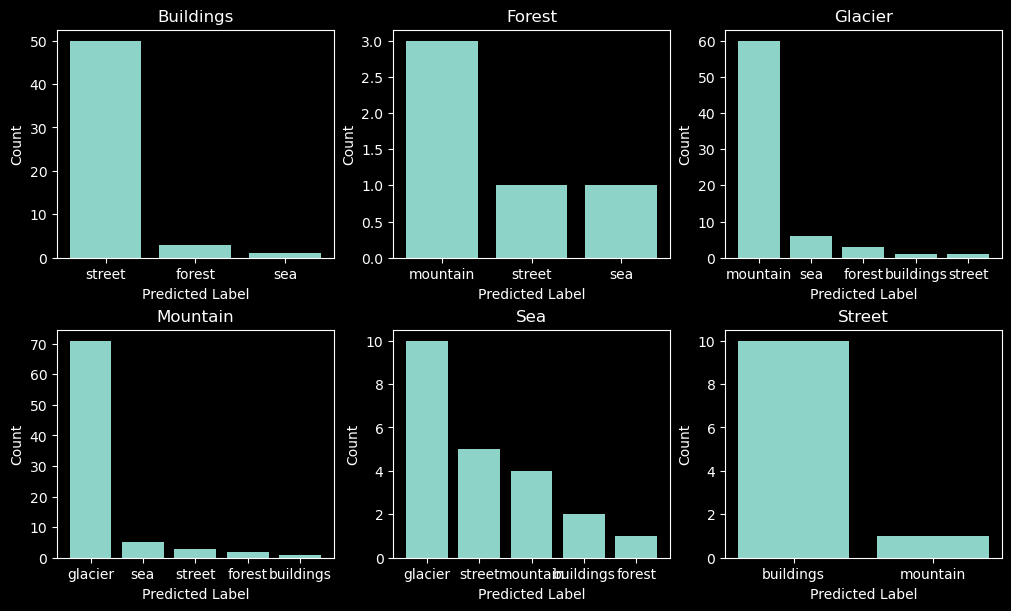

In [19]:
error_df = pd.DataFrame({'true_label': true_labels, 'pred_label': pred_labels})
error_df = error_df[true_labels != pred_labels].reset_index(drop=True)
error_df.true_label = error_df.apply(lambda row: class_names[row['true_label']], axis=1)
error_df.pred_label = error_df.apply(lambda row: class_names[row['pred_label']], axis=1)

fig, axes = plt.subplots(2, 3, figsize=(10, 6), layout='constrained')
for label, ax in zip(class_names, axes.ravel()):
    label_df = error_df[error_df.true_label == label]
    ax.bar(label_df.pred_label.value_counts().index, label_df.pred_label.value_counts().values)
    ax.set_title(label.title())
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('Count')
plt.show()

# Add Dropout

In [20]:
# Replace the last fully connected layer with a new one, inclusive of dropout
model.fc = nn.Sequential(
    nn.Dropout(DROPOUT), 
    nn.Linear(num_ftrs, 6)
)

model.fc

Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=2048, out_features=6, bias=True)
)

#### Re-run Training

In [21]:
# Transfer the model to GPU if available
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = OPTIMIZER(model.fc.parameters(), lr=LEARNING_RATE)

# Set up variables
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
start = time()

# Train model
for epoch in range(NUM_EPOCHS):

    if epoch % (NUM_EPOCHS // 10) == 0 or epoch == NUM_EPOCHS - 1:
        print(f'\nEpoch {epoch + 1}/{NUM_EPOCHS} - Time Elapsed: {(time() - start) / 60:.2f} minutes\n----------')

    # Repeat for training and validation
    for phase in ['train', 'val']:
        # Set model to training mode or evaluation mode
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)

        if epoch % (NUM_EPOCHS // 10) == 0 or epoch == NUM_EPOCHS - 1:
            print(f'{phase.title()} Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}')

torch.save(model, 'models/dropout_model.pt')


Epoch 1/100 - Time Elapsed: 0.00 minutes
----------
Train Loss: 0.5894 - Accuracy: 0.7866
Val Loss: 0.2806 - Accuracy: 0.9003

Epoch 11/100 - Time Elapsed: 4.48 minutes
----------
Train Loss: 0.4567 - Accuracy: 0.8290
Val Loss: 0.2581 - Accuracy: 0.9040

Epoch 21/100 - Time Elapsed: 8.94 minutes
----------
Train Loss: 0.4375 - Accuracy: 0.8415
Val Loss: 0.2919 - Accuracy: 0.9010

Epoch 31/100 - Time Elapsed: 13.42 minutes
----------
Train Loss: 0.4426 - Accuracy: 0.8375
Val Loss: 0.2619 - Accuracy: 0.9047

Epoch 41/100 - Time Elapsed: 17.89 minutes
----------
Train Loss: 0.4446 - Accuracy: 0.8391
Val Loss: 0.2413 - Accuracy: 0.9157

Epoch 51/100 - Time Elapsed: 22.37 minutes
----------
Train Loss: 0.4470 - Accuracy: 0.8372
Val Loss: 0.2405 - Accuracy: 0.9120

Epoch 61/100 - Time Elapsed: 26.85 minutes
----------
Train Loss: 0.4448 - Accuracy: 0.8365
Val Loss: 0.2659 - Accuracy: 0.9063

Epoch 71/100 - Time Elapsed: 31.33 minutes
----------
Train Loss: 0.4411 - Accuracy: 0.8403
Val Loss

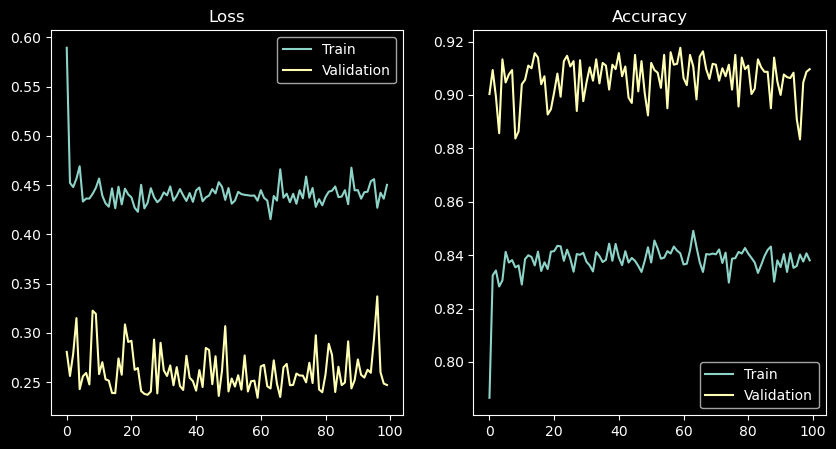

In [22]:
# Plot losses and accuracies
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(train_losses, label='Train')
axes[0].plot(val_losses, label='Validation')
axes[0].set_title('Loss')
axes[0].legend()

axes[1].plot([x.detach().cpu().numpy() for x in train_accuracies], label='Train')
axes[1].plot([x.detach().cpu().numpy() for x in val_accuracies], label='Validation')
axes[1].set_title('Accuracy')
axes[1].legend()

plt.show()

In [23]:
# Set up variables
true_labels = []
pred_labels = []

# Loop through validation set
for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Generate predictions
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Convert to numpy arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Log classification report
class_report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)
class_report = pd.DataFrame(class_report).transpose()
class_report.to_csv('logs/class_report_dropout.csv')

# Print string version
print(classification_report(true_labels, pred_labels, target_names=class_names))

              precision    recall  f1-score   support

   buildings       0.92      0.93      0.92       500
      forest       0.99      0.98      0.99       500
     glacier       0.87      0.79      0.83       500
    mountain       0.79      0.90      0.84       500
         sea       0.97      0.94      0.96       500
      street       0.93      0.92      0.93       500

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



# Add More Data Augmentations

In [24]:
data_transforms = {
    'train': transforms.Compose([
        # Original transforms
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        # Additional transforms
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        # Conversion and normalization
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(os.path.join('data', x), data_transforms[x])
    for x in ['train', 'val', 'test']
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
    for x in ['train', 'val', 'test']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

print(
    f'Class names: {class_names}'
    f'\nDataset sizes: {dataset_sizes}'
)

Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Dataset sizes: {'train': 11034, 'val': 3000, 'test': 3000}


#### Re-run model training

In [25]:
# Re-instantiate model (without dropout)
model = models.resnet50(weights='IMAGENET1K_V1')

# Freeze all the parameters in the network
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer with a new one with 6 output classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)

# Move to GPU
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = OPTIMIZER(model.fc.parameters(), lr=LEARNING_RATE)

# Set up variables
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
start = time()

# Train model
for epoch in range(NUM_EPOCHS):

    if epoch % (NUM_EPOCHS // 10) == 0 or epoch == NUM_EPOCHS - 1:
        print(f'\nEpoch {epoch + 1}/{NUM_EPOCHS} - Time Elapsed: {(time() - start) / 60:.2f} minutes\n----------')

    # Repeat for training and validation
    for phase in ['train', 'val']:
        # Set model to training mode or evaluation mode
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)

        if epoch % (NUM_EPOCHS // 10) == 0 or epoch == NUM_EPOCHS - 1:
            print(f'{phase.title()} Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}')

torch.save(model, 'models/augments_model.pt')


Epoch 1/100 - Time Elapsed: 0.00 minutes
----------
Train Loss: 0.6472 - Accuracy: 0.7659
Val Loss: 0.2833 - Accuracy: 0.8927

Epoch 11/100 - Time Elapsed: 5.09 minutes
----------
Train Loss: 0.5924 - Accuracy: 0.7879
Val Loss: 0.3057 - Accuracy: 0.8870

Epoch 21/100 - Time Elapsed: 10.17 minutes
----------
Train Loss: 0.5794 - Accuracy: 0.7890
Val Loss: 0.3196 - Accuracy: 0.8813

Epoch 31/100 - Time Elapsed: 15.26 minutes
----------
Train Loss: 0.5556 - Accuracy: 0.7955
Val Loss: 0.3015 - Accuracy: 0.8913

Epoch 41/100 - Time Elapsed: 20.36 minutes
----------
Train Loss: 0.5505 - Accuracy: 0.7977
Val Loss: 0.3416 - Accuracy: 0.8630

Epoch 51/100 - Time Elapsed: 25.45 minutes
----------
Train Loss: 0.5665 - Accuracy: 0.7923
Val Loss: 0.2858 - Accuracy: 0.8970

Epoch 61/100 - Time Elapsed: 30.55 minutes
----------
Train Loss: 0.5714 - Accuracy: 0.7908
Val Loss: 0.2766 - Accuracy: 0.9017

Epoch 71/100 - Time Elapsed: 35.65 minutes
----------
Train Loss: 0.5587 - Accuracy: 0.7954
Val Los

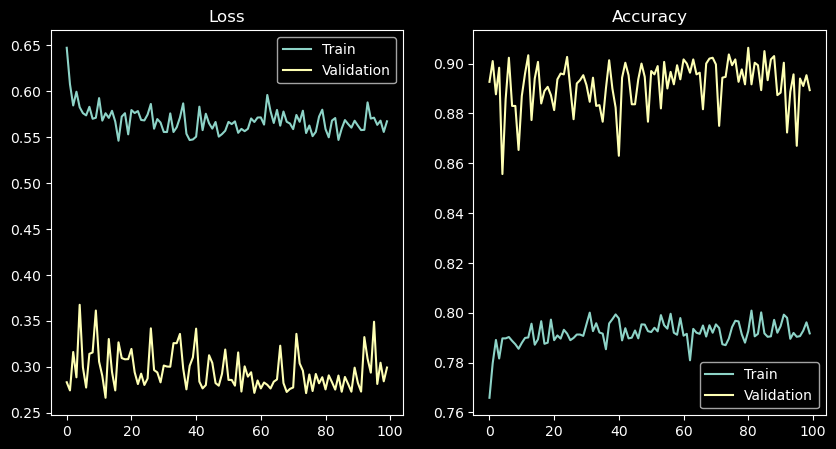

In [26]:
# Plot losses and accuracies
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(train_losses, label='Train')
axes[0].plot(val_losses, label='Validation')
axes[0].set_title('Loss')
axes[0].legend()

axes[1].plot([x.detach().cpu().numpy() for x in train_accuracies], label='Train')
axes[1].plot([x.detach().cpu().numpy() for x in val_accuracies], label='Validation')
axes[1].set_title('Accuracy')
axes[1].legend()

plt.show()

In [27]:
# Set up variables
true_labels = []
pred_labels = []

# Loop through validation set
for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Generate predictions
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Convert to numpy arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Log classification report
class_report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)
class_report = pd.DataFrame(class_report).transpose()
class_report.to_csv('logs/class_report_augments.csv')

# Print string version
print(classification_report(true_labels, pred_labels, target_names=class_names))

              precision    recall  f1-score   support

   buildings       0.87      0.94      0.91       500
      forest       0.99      0.98      0.99       500
     glacier       0.75      0.88      0.81       500
    mountain       0.85      0.78      0.81       500
         sea       0.97      0.87      0.92       500
      street       0.94      0.88      0.91       500

    accuracy                           0.89      3000
   macro avg       0.90      0.89      0.89      3000
weighted avg       0.90      0.89      0.89      3000



# Unfreeze Additional Layers

In [28]:
# View model layers
for name, _ in model.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [29]:
# Unfreeze layers 3 and 4
for name, child in model.named_children():
    if name in ['layer3', 'layer4', 'fc']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

# Check the requires_grad attribute for each parameter layer
for name, child in model.named_children():
    counter = 0
    for param in child.parameters():
        if param.requires_grad:
            counter += 1
    if counter == len(list(child.parameters())):
        print(f'{name}: unfrozen')
    elif counter == 0:
        print(f'{name}: frozen')
    else:
        print(f'{name}: partially frozen - {counter} of {len(list(child.parameters()))}')

conv1: frozen
bn1: frozen
relu: unfrozen
maxpool: unfrozen
layer1: frozen
layer2: frozen
layer3: unfrozen
layer4: unfrozen
avgpool: unfrozen
fc: unfrozen


<i>NOTE: the `relu`, `maxpool` and `avgpool` layers all have zero trainable parameters, so therefore appear as frozen.<i>

#### Re-run model training

In [30]:
# Transfer the model to GPU
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = OPTIMIZER(model.fc.parameters(), lr=LEARNING_RATE)

# Set up variables
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
start = time()

# Train model
for epoch in range(NUM_EPOCHS):

    if epoch % (NUM_EPOCHS // 10) == 0 or epoch == NUM_EPOCHS - 1:
        print(f'\nEpoch {epoch + 1}/{NUM_EPOCHS} - Time Elapsed: {(time() - start) / 60:.2f} minutes\n----------')

    # Repeat for training and validation
    for phase in ['train', 'val']:
        # Set model to training mode or evaluation mode
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)

        if epoch % (NUM_EPOCHS // 10) == 0 or epoch == NUM_EPOCHS - 1:
            print(f'{phase.title()} Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}')

torch.save(model, 'models/unfrozen_model.pt')


Epoch 1/100 - Time Elapsed: 0.00 minutes
----------
Train Loss: 0.5742 - Accuracy: 0.7893
Val Loss: 0.2757 - Accuracy: 0.9083

Epoch 11/100 - Time Elapsed: 5.34 minutes
----------
Train Loss: 0.5611 - Accuracy: 0.7943
Val Loss: 0.2777 - Accuracy: 0.9023

Epoch 21/100 - Time Elapsed: 10.69 minutes
----------
Train Loss: 0.5453 - Accuracy: 0.7982
Val Loss: 0.2750 - Accuracy: 0.9023

Epoch 31/100 - Time Elapsed: 16.04 minutes
----------
Train Loss: 0.5704 - Accuracy: 0.7920
Val Loss: 0.2754 - Accuracy: 0.9037

Epoch 41/100 - Time Elapsed: 21.40 minutes
----------
Train Loss: 0.5578 - Accuracy: 0.7945
Val Loss: 0.2785 - Accuracy: 0.8950

Epoch 51/100 - Time Elapsed: 26.76 minutes
----------
Train Loss: 0.5804 - Accuracy: 0.7872
Val Loss: 0.3054 - Accuracy: 0.8930

Epoch 61/100 - Time Elapsed: 32.09 minutes
----------
Train Loss: 0.5668 - Accuracy: 0.7921
Val Loss: 0.2918 - Accuracy: 0.8923

Epoch 71/100 - Time Elapsed: 37.45 minutes
----------
Train Loss: 0.5759 - Accuracy: 0.7894
Val Los

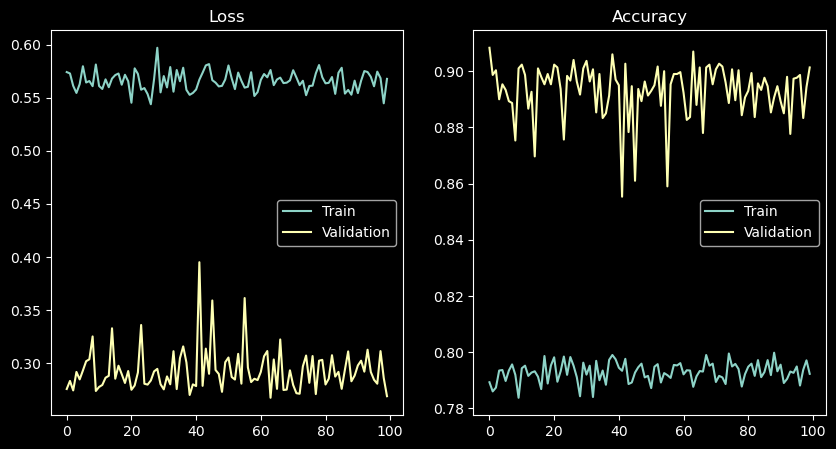

In [31]:
# Plot losses and accuracies
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(train_losses, label='Train')
axes[0].plot(val_losses, label='Validation')
axes[0].set_title('Loss')
axes[0].legend()

axes[1].plot([x.detach().cpu().numpy() for x in train_accuracies], label='Train')
axes[1].plot([x.detach().cpu().numpy() for x in val_accuracies], label='Validation')
axes[1].set_title('Accuracy')
axes[1].legend()

plt.show()

In [32]:
# Set up variables
true_labels = []
pred_labels = []

# Loop through validation set
for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Generate predictions
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Convert to numpy arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Log classification report
class_report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)
class_report = pd.DataFrame(class_report).transpose()
class_report.to_csv('logs/class_report_unfrozen.csv')

# Print string version
print(classification_report(true_labels, pred_labels, target_names=class_names))

              precision    recall  f1-score   support

   buildings       0.89      0.93      0.91       500
      forest       0.99      0.98      0.99       500
     glacier       0.83      0.83      0.83       500
    mountain       0.83      0.83      0.83       500
         sea       0.93      0.95      0.94       500
      street       0.93      0.90      0.91       500

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



# Final Model Evaluation

In [33]:
# Save model
torch.save(model, 'models/final_model.pt')

# Set up variables
true_labels = []
pred_labels = []

# Loop through validation set
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Generate predictions
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Convert to numpy arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Log classification report
class_report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)
class_report = pd.DataFrame(class_report).transpose()
class_report.to_csv('logs/class_report_final.csv')

# Print string version
print(classification_report(true_labels, pred_labels, target_names=class_names))

              precision    recall  f1-score   support

   buildings       0.88      0.92      0.90       437
      forest       0.99      0.99      0.99       474
     glacier       0.84      0.81      0.83       553
    mountain       0.84      0.83      0.83       525
         sea       0.91      0.95      0.93       510
      street       0.91      0.88      0.90       501

    accuracy                           0.89      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.89      0.89      0.89      3000



#### Compare All Model Results

In [54]:
# Create results dataframe
results_df = pd.DataFrame()

# Loop through model results
for model_type in ['baseline', 'dropout', 'augments', 'unfrozen', 'final']:
    error_df = pd.read_csv(f'logs/class_report_{model_type}.csv', index_col=0)
    accuracy = error_df.loc['accuracy', 'precision']
    precision = error_df.loc['macro avg', 'precision']
    recall = error_df.loc['macro avg', 'recall']
    f1 = error_df.loc['macro avg', 'f1-score']
    # Add results to dataframe
    results_df = pd.concat([results_df, pd.DataFrame({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }, index=[model_type])], axis=0)

# Print results
results_df

,accuracy,precision,recall,f1
baseline,0.918333,0.919533,0.918333,0.918266
dropout,0.909667,0.912112,0.909667,0.909936
augments,0.889333,0.895482,0.889333,0.890344
unfrozen,0.901333,0.901492,0.901333,0.901283
final,0.893667,0.895239,0.896789,0.895773
